In [1]:
%load_ext autoreload
%autoreload 2
from utils import *
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [2]:
twitter_db = connect_to_db()

In [3]:
N = 10000
cursor = twitter_db.cursor()

query = ("SELECT t1.user_id, t1.in_reply_to_user_id, t1.quoted_user_id, t1.retweeted_user_id \
        FROM tweets t1\
        WHERE lang='fr' AND \
        ((NOT (t1.text LIKE '%RT @%')) OR \
        (t1.text LIKE '%RT @%' AND \
            EXISTS \
                (SELECT * \
                FROM tweets t2 \
                WHERE t2.user_id = t1.user_id AND NOT (t2.text LIKE '%RT @%')\
                )\
        )\
        )\
        LIMIT " + str(N))

cursor.execute(query)

In [4]:
G_dict = dict()

for (user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id) in cursor:
    #print(user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id)
    if user_id not in G_dict:
        G_dict[user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        
    if not(in_reply_to_user_id is None):
        if in_reply_to_user_id not in G_dict:
            G_dict[in_reply_to_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if in_reply_to_user_id not in G_dict[user_id]['replied_to']:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] = 1
        else:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] += 1
            
    if not(quoted_user_id is None):
        if quoted_user_id not in G_dict:
            G_dict[quoted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if quoted_user_id not in G_dict[user_id]['quoted']:
            G_dict[user_id]['quoted'][quoted_user_id] = 1
        else:
            G_dict[user_id]['quoted'][quoted_user_id] += 1
    
    if not(retweeted_user_id is None):
        if retweeted_user_id not in G_dict:
            G_dict[retweeted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if retweeted_user_id not in G_dict[user_id]['retweeted']:
            G_dict[user_id]['retweeted'][retweeted_user_id] = 1
        else:
            G_dict[user_id]['retweeted'][retweeted_user_id] += 1
    
cursor.close()       

True

In [5]:
G = nx.DiGraph()
G.add_nodes_from(G_dict.keys())

for (u1,v) in G_dict.items():
    for (u2, count) in v['quoted'].items():
        #print("quoted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='quoted',weight=count)
    for (u2, count) in v['replied_to'].items():
        #print("replied to : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='replied_to',weight=count)
    for (u2, count) in v['retweeted'].items():
        #print("retweeted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='retweeted',weight=count)

In [6]:
G_undirected = nx.Graph(G)

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


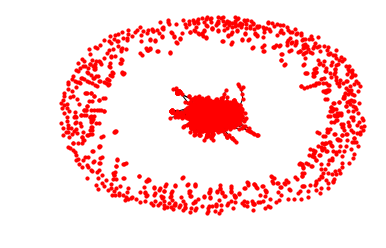

In [375]:
spring_pos = nx.spring_layout(G_undirected)
plt.axis('off')
nx.draw_networkx(G_undirected, pos=spring_pos, with_labels=False, node_size=10)

In [248]:
parts = community_louvain.best_partition(G_undirected)
values = [parts.get(node) for node in G_undirected.nodes()]

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


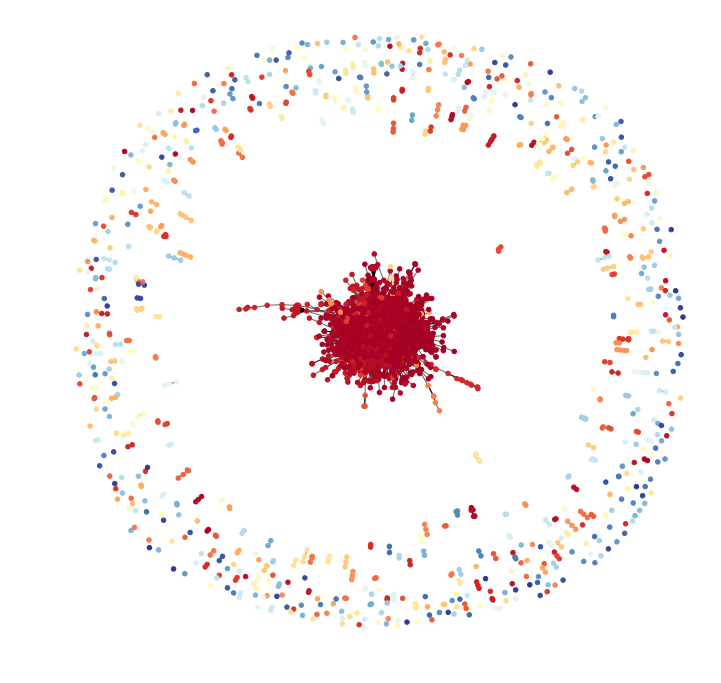

In [249]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_undirected, spring_pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=values)
nx.draw_networkx_edges(G_undirected, spring_pos, alpha=0.6)
plt.axis('off')
plt.show(G_undirected)

In [310]:
nb_partitions = len(np.unique(values))
nb_partitions

705

In [268]:
c = Counter(values)

In [312]:
groups_sorted = sorted(np.unique(values), key=c.get, reverse=True)

In [313]:
len(groups_sorted)

705

In [317]:
groups_counts = []
for group_id in groups_sorted:
    groups_counts.append((group_id, c[group_id]))
groups_counts = np.array(groups_counts)

In [346]:
groups_counts[np.where(groups_counts[:,1] < 10)][:,1].sum()

1017

In [347]:
groups_counts[np.where(groups_counts[:,1] >= 10)][:,1].sum()

4011

In [380]:
groups_filtered = groups_counts[np.where(groups_counts[:,1] >= 500)]

In [385]:
groups_filtered[:,0]

array([7, 3, 2])

In [381]:
parts_filtered = dict()
G_filtered = G.copy()
for user_id, group in parts.items():
    if group in groups_filtered[:,0]:
        parts_filtered[user_id] = group
    else:
        G_filtered.remove_node(user_id)

In [382]:
np.unique(list(parts_filtered.values()))

array([2, 3, 7])

In [383]:
values_filtered = [parts_filtered.get(node) for node in G_filtered.nodes()]

In [402]:
spring_pos_filtered = nx.spring_layout(G_filtered)

In [386]:
len(list(G_filtered.nodes()))

1837

In [387]:
np.unique(values_filtered)

array([2, 3, 7])

(-1.174574065208435,
 1.206633734703064,
 -1.1818492129445075,
 1.1919765785336494)

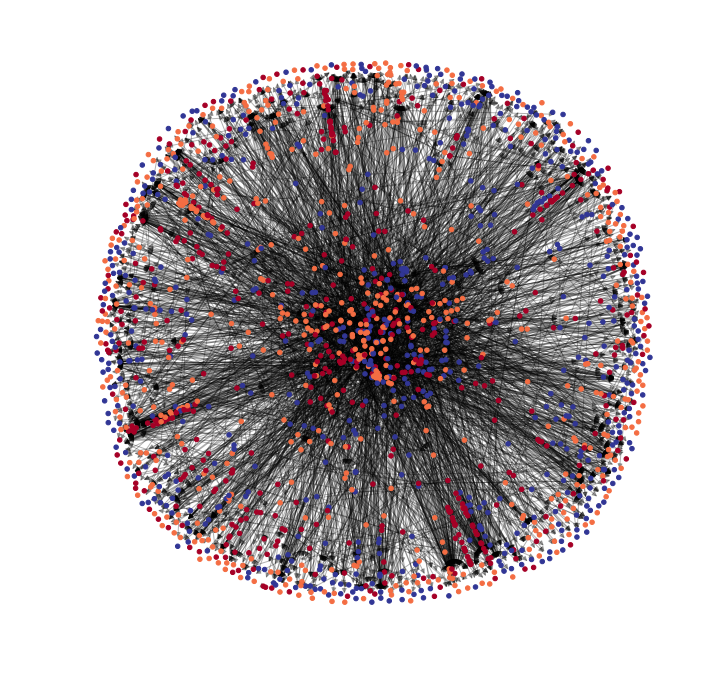

In [404]:
plt.figure(figsize=(12, 12))
#nx.draw_networkx(G_filtered, spring_pos_filtered, node_size=20, cmap=plt.cm.RdYlBu, node_color=values_filtered)
nx.draw_networkx_nodes(G_filtered, spring_pos_filtered, node_size=20, cmap=plt.cm.RdYlBu, node_color=values_filtered)
nx.draw_networkx_edges(G_filtered, spring_pos_filtered, alpha=0.3)
plt.axis('off')
#plt.show(G_filtered)